# Loading ECCO V4 Netcdf Files

Ian Fenty, updated 2025-05-20

## Introduction

This tutorial covers different approaches to loading ECCO V4 Netcdf files that are stored on your local disk and "in the cloud" in different AWS "S3" Buckets. 

ECCO V4r4 files are stored in an S3 bucket managed by NASA's PO.DAAC. Accessing these files requires setting up a NASA EarthData credential. These files can be accessed from anywhere.

ECCO V4r5 files are stored in a different bucket. Accessing these files doesn't require a NASA EarthData credential. These files are best accessed from cloud-based computer (which we have for the summer school).

The tutorial also covers the concepts
* fully loading files into memory [slow ] vs. lazy-loading files [much faster]
* 'direct' cloud access [slow] vs. 'referenced-based' cloud access [much faster]


In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr


In [2]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [3]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [4]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

## METHOD 1: LOADING FILES STORED ON A "LOCAL" DISK

### FIND THE GRANULES

Many ECCO V4r5 fields are stored on the /efs_ecco disk
```
Native Grid:
    monthly means    /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/
    daily snapshots  /efs_ecco/ECCO/V4/r5/netcdf/native/snap/
    geometry         /efs_ecco/ECCO/V4/r5/netcdf/native/geometry
    
Latlon Grid
    monthly means    /efs_ecco/ECCO/V4/r5/netcdf/latlon/mon_mean
    geometry         /efs_ecco/ECCO/V4/r5/netcdf/latlon/geometry
```

Let's start by opening and plotting one of these fields, 


In [5]:
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    print(str(i).zfill(3),d)

000 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/.ipynb_checkpoints
001 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ATM_SURFACE_TEMP_HUM_WIND_PRES
002 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/FINAL_TEMP_SAL_ANOMALY.ipynb
003 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_FRONT_FLUX
004 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_SHELF_FLUX
005 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_X
006 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_Y
007 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_X
008 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_Y
009 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_X
010 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_Y
011 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_FW_FLUX
012 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX
013 /efs_ecco/ECCO/V4/r5/netcdf/nativ

#### Get the filenames for some dataset

In [6]:
# Select a dataset (the one containing temperature and salinity)
dataset_num = 19

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
TS_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
TS_dataset_files = np.sort(list(TS_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in TS_dataset_files[:5]])


selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_SALINITY_FLUX

First 5 files
['OCEAN_SALINITY_FLUX_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_SALINITY_FLUX_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_SALINITY_FLUX_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_SALINITY_FLUX_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_SALINITY_FLUX_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']


### LOAD A SINGLE GRANULE

#### Select a file to open

In [7]:
# choose a file from the file list
file_to_open = TS_dataset_files[100]
print(f'\nfile to open --> {file_to_open.name}')


file to open --> OCEAN_SALINITY_FLUX_mon_mean_2000-05_ECCO_V4r5_native_llc0090.nc


#### Load the netcdf file into memory with xarray 'open_dataset':

In [8]:
# start timer
start_time = time.time()

# load the file into memory (note 'load' command at the end)
single_granule_ds = xr.open_dataset(file_to_open).load(); 

# stop timer
total_time = time.time() - start_time

print('\nloaded single granule')
print(f'total time {total_time:.2f} sec')
print('time level : ' , single_granule_ds.time.values[0])

# show contents of single granule
single_granule_ds


loaded single granule
total time 1.96 sec
time level :  2000-05-16T12:00:00.000000000


<xarray.Dataset> Size: 174MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl         (k_l) float32 200B 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    time_bnds  (time, nv) datetime64[ns] 16B 2000-05-01 2000-06-01
    XC_bnds    (tile, j, i, nb) float32 2MB -115.0 -115.0 ... -115.0 -108.5
    YC_bnds    (tile, j, i, nb) float32 2MB -88.18 -88.32 ... -88.18 -88.16
    Z_bnds     (k, nv) float32 400B 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
Dimensions without coordinates: nv, nb
Data variables:
    ADVx_SLT   (time, k, tile, j, i_g) float32 21MB nan nan nan ... nan nan nan
    DFxE_SLT   (time, k, tile, j, i_g) float32 21MB nan nan nan ... nan nan nan
    ADVy_SLT   (time, k, tile, j_g, i) float32 21MB nan nan nan ... nan nan nan
    DFyE_SLT   (time, k, tile, j_g, i) float32 21MB nan nan nan ... nan nan nan
    ADVr_SLT   (time, k_l, tile, j, i) float32 21MB nan nan nan ... nan nan nan
    DFrE_SLT   (time, k_l, tile, j, i) float32 21MB nan nan nan ... nan nan nan
    DFrI_SLT   (time, k_l, tile, j, i) float32 21MB nan nan nan ... nan nan nan
    oceSPtnd   (time, k, tile, j, i) float32 21MB nan nan nan ... nan nan nan
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2000-06-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2000-05-01T00:00:00
    title:                           ECCO Ocean Salinity Fluxes - Monthly Mea...
    uuid:                            cc6050d8-2718-11f0-91df-0a58a9feac02

#### Plot one data variable

In [20]:
# Select the first variable, 'THETA'
print(single_granule_ds['THETA'].dims)

print('\ndimension length')
print('----------------')
for d in single_granule_ds['THETA'].dims:
    print(f'{d.rjust(6)} {str(len(single_granule_ds[d])).rjust(6)}')

# when plotting a 2D field in the native grid format
# it can only have 3 dimensions (tile, j, and i)

# the 'isel' command lets us select one time level and one depth level
# in this case, we are selected the surface vertical level (k=0)
# the first time level (time=0)
T_surf = single_granule_ds['THETA'].isel(k=0, time=0)

print('\nafter squeezing out the depth (k) and time (time) dimensions')
for d in T_surf.dims:
    print(f'{d.rjust(6)} {str(len(single_granule_ds[d])).rjust(6)}')
    

('time', 'k', 'tile', 'j', 'i')

dimension length
----------------
  time      1
     k     50
  tile     13
     j     90
     i     90

after squeezing out the depth (k) and time (time) dimensions
  tile     13
     j     90
     i     90


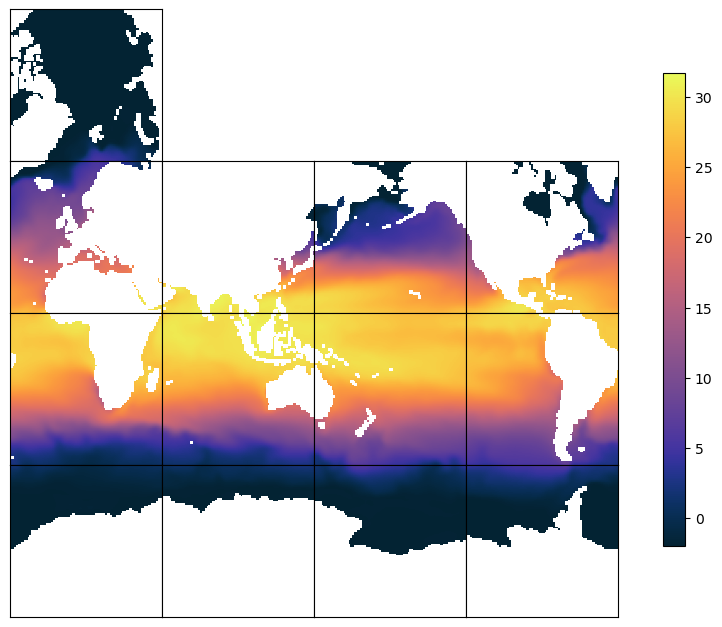

In [21]:
# Plot the example data variable using the 'plot_tiles'
# a helper function of ecco_v4_py
ecco.plot_tiles(T_surf, layout='latlon', 
                rotate_to_latlon=True, 
                show_tile_labels=False, 
                show_colorbar=True, 
                cmap=cmocean.cm.thermal,
                cmin=-2,cmax=T_surf.max().values);

### LOAD MULTIPLE GRANULES


In [10]:
# In this example, open 48 granules files (first 4 years)
files_to_load = TS_dataset_files[:48]

# expected memory footprint for 48 granules, each with 2 3D fields (t
# 13*90*90 : # of horizontal grid points
# 50       : # of vertical levels
# 2        : # of fields (theta, salt)
# 48       : # of time levels
# 4        : # of bytes per number (single precision float)

print(f'expected memory size (gb): {(13*90*90)*50*2*48*4/ 1e9:.3g} gb') # 120

expected memory size (gb): 2.02 gb


#### Option 1: use 1 cpu

#### Load each netcdf file into memory with xarray 'open_dataset':

In [11]:
start_time = time.time();

# create an empty list to contain the loaded granles
# ds for dataste
ds = []

# OG method, load one at a time.
print(f'Loading {len(files_to_load)} granules ...')
for f in files_to_load:
    # load a current granule, append to the list
    ds.append(xr.open_dataset(f))
    print('.', end='', flush=True)

print('\n')
print('combining individual DataArrays in the list into a single mega xarray DataSet object')
print('using one process (takes ~25 seconds')

# use xarray's "concat" command
ds = xr.concat(ds, dim='time',
               combine_attrs='override', 
               compat='no_conflicts')

total_time = time.time() - start_time


print(f'\nloaded {len(files_to_load)} granules')
print(f'total time {total_time:.2f} sec')
print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')
print('\n')
print('first time level : ' , ds.time.values[0])
print('last time level  : ' , ds.time.values[-1])
print('# of granules    : ', len(ds.time.values))

print(f'\nds object is {getsize(ds)/1e9:.3g} gb')
ds

Loading 48 granules ...
...............................................

combining individual DataArrays in the list into a single mega xarray DataSet object
using one process (takes ~25 seconds

loaded 48 granules
total time 46.08 sec
time per granule 0.96 grans/sec


first time level :  1992-01-16T18:00:00.000000000
last time level  :  1995-12-16T12:00:00.000000000
# of granules    :  48

ds object is 8.09 gb


<xarray.Dataset> Size: 8GB
Dimensions:    (time: 48, k: 50, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90,
                k_l: 50, k_u: 50, k_p1: 51, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl         (k_l) float32 200B 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    time_bnds  (time, nv) datetime64[ns] 768B 1992-01-01T12:00:00 ... 1996-01-01
    XC_bnds    (tile, j, i, nb) float32 2MB -115.0 -115.0 ... -115.0 -108.5
    YC_bnds    (tile, j, i, nb) float32 2MB -88.18 -88.32 ... -88.18 -88.16
    Z_bnds     (k, nv) float32 400B 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
Dimensions without coordinates: nv, nb
Data variables:
    ADVx_SLT   (time, k, tile, j, i_g) float32 1GB nan nan nan ... nan nan nan
    DFxE_SLT   (time, k, tile, j, i_g) float32 1GB nan nan nan ... nan nan nan
    ADVy_SLT   (time, k, tile, j_g, i) float32 1GB nan nan nan ... nan nan nan
    DFyE_SLT   (time, k, tile, j_g, i) float32 1GB nan nan nan ... nan nan nan
    ADVr_SLT   (time, k_l, tile, j, i) float32 1GB nan nan nan ... nan nan nan
    DFrE_SLT   (time, k_l, tile, j, i) float32 1GB nan nan nan ... nan nan nan
    DFrI_SLT   (time, k_l, tile, j, i) float32 1GB nan nan nan ... nan nan nan
    oceSPtnd   (time, k, tile, j, i) float32 1GB nan nan nan nan ... nan nan nan
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Salinity Fluxes - Monthly Mea...
    uuid:                            11aa1e4c-2784-11f0-9047-0a58a9feac02

#### Example calculation

In [24]:
# take mean temperature in the uppermost grid cell over all
st = time.time()

T_mean_k0 = ds.THETA.isel(k=0).mean(dim='time').compute()

total_time = time.time() - st
print(f'total time to compute the mean temperature {total_time:.3g}s')

total time to compute the mean temperature 0.554s


#### Plot result

Mean Ocean Temperature from 0-10m : 
1992-01-01
1996-01-01


<Figure size 1400x600 with 0 Axes>

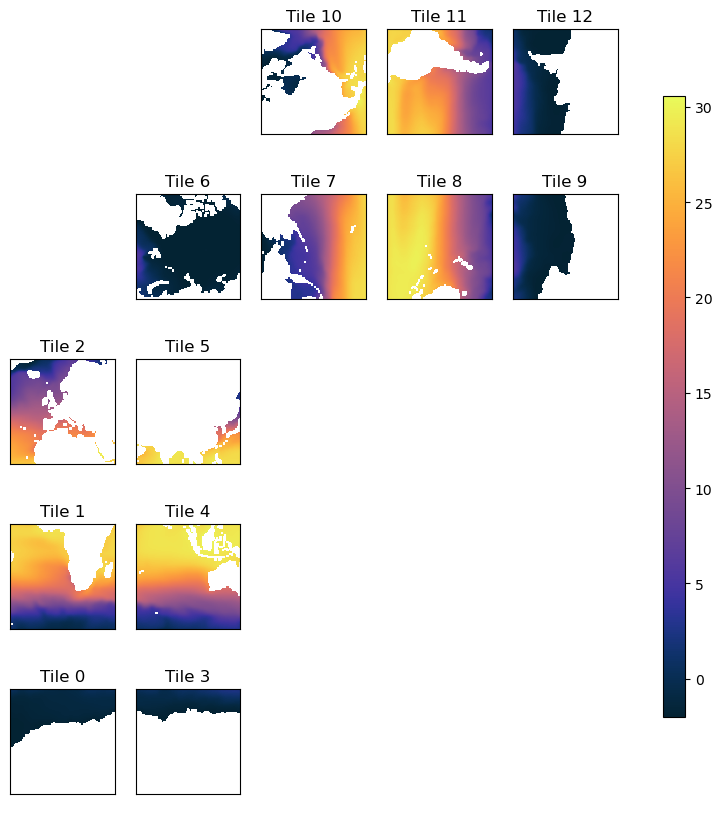

In [25]:
# Butterfly

plt.figure(figsize=[14,6]);

ecco.plot_tiles(T_mean_k0, show_colorbar=True, 
                cmin=-2, cmax=T_mean_k0.max(), cmap=cmocean.cm.thermal);

print(f'Mean Ocean Temperature from 0-10m : ')
print(f'{str(ds.time_bnds[0][0].values)[:10]}')
print(f'{str(ds.time_bnds[-1][-1].values)[:10]}')

Mean Ocean Temperature from 0-10m :     1992-01-01 to     1996-01-01 


<Figure size 1400x600 with 0 Axes>

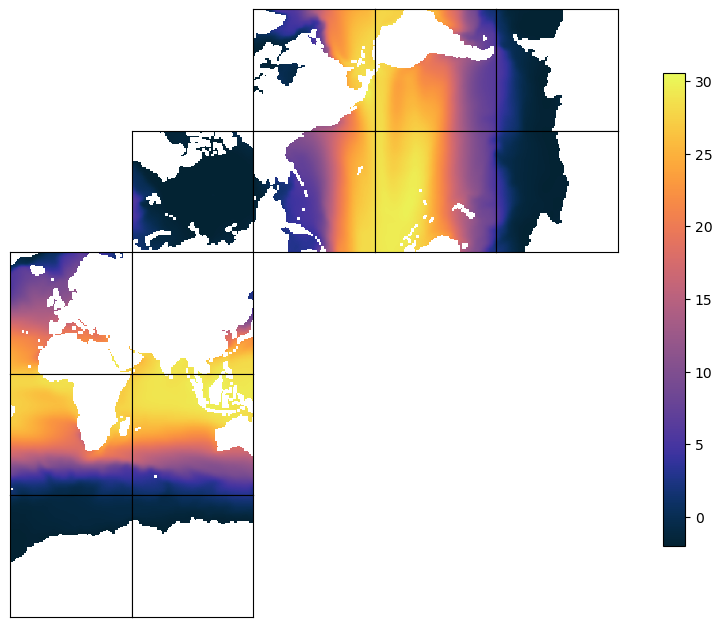

In [27]:
# Tiles rotated and placed closed together

plt.figure(figsize=[14,6]);

ecco.plot_tiles(T_mean_k0, show_colorbar=True, 
                cmin=-2, cmax=T_mean_k0.max(), 
                cmap=cmocean.cm.thermal, 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=False);

print(f'Mean Ocean Temperature from 0-10m : \
    {str(ds.time_bnds[0][0].values)[:10]} to \
    {str(ds.time_bnds[-1][-1].values)[:10]} ')


Text(0.5, 1.0, 'Mean Ocean Temperature from 0-10m : 1992-01-01 to 1996-01-01 ')

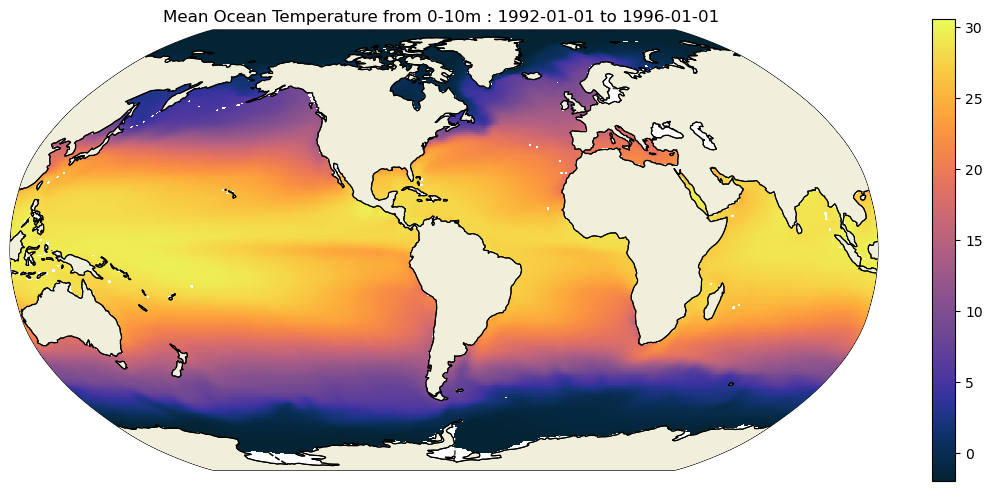

In [19]:
# Mapped to Lat-lon and plotted in Robinson Project (Carl's preference)
plt.figure(figsize=[14,6]);

ecco.plot_proj_to_latlon_grid(T_mean_k0.XC, T_mean_k0.YC, 
                              T_mean_k0, 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-2, cmax=T_mean_k0.max(), 
                              cmap=cmocean.cm.thermal);

plt.title(f'Mean Ocean Temperature from 0-10m : {str(ds.time_bnds[0][0].values)[:10]} to ' +
                    f'{str(ds.time_bnds[-1][-1].values)[:10]} ')

#### Option 2: Load into memory use multiple cpus via Dask 

#### Connect to Dask client

Started a dask client (left side of JupyterHub panel), and connect to it (click <>)

In [21]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:35009")
client.ncores
client.restart()

#### Load all netcdf file into memory with xarray 'open_mfdataset':

In [22]:
print(f'loading {len(files_to_load)} files')

loading 48 files


In [23]:
start_time = time.time();
ds = None

# first lazy load
ds = xr.open_mfdataset(files_to_load, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

# then load into memory
ds.load()

total_time = time.time() - start_time

print(f'\nloaded multiple {len(files_to_load)} granules')
print(f'total time {total_time:.2f} sec')
print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')
print('\n')
print('first time level : ' , ds.time.values[0])
print('last time level  : ' , ds.time.values[-1])
print('# of granules    : ', len(ds.time.values))


loaded multiple 48 granules
total time 16.75 sec
time per granule 0.35 grans/sec


first time level :  1992-01-16T18:00:00.000000000
last time level  :  1995-12-16T12:00:00.000000000
# of granules    :  48


In [24]:
# take mean temperature in the uppermost grid cell over all
st = time.time()

T_mean_k0 = ds.THETA.isel(k=0).mean(dim='time').compute()

total_time = time.time() - st
print(f'total time to compute the mean temperature {total_time:.3g}s')


total time to compute the mean temperature 0.00423s


#### Option 3: Lazy load use multiple cpus via Dask 

In [25]:
start_time = time.time();
ds = None

# first lazy load
ds = xr.open_mfdataset(files_to_load, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

# don't load into memory until needed!
# ds.load()

total_time = time.time() - start_time

print(f'\nloaded multiple {len(files_to_load)} granules')
print(f'total time {total_time:.2f} sec')
print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')
print('\n')
print('first time level : ' , ds.time.values[0])
print('last time level  : ' , ds.time.values[-1])
print('# of granules    : ', len(ds.time.values))


loaded multiple 48 granules
total time 1.58 sec
time per granule 0.03 grans/sec


first time level :  1992-01-16T18:00:00.000000000
last time level  :  1995-12-16T12:00:00.000000000
# of granules    :  48


In [26]:
# take mean temperature in the uppermost grid cell over all
st = time.time()

# the *.compute() command tells dask to do the calculation
T_mean_k0 = ds.THETA.isel(k=0).mean(dim='time').compute()

total_time = time.time() - st
print(f'total time to compute the mean temperature {total_time:.3g}s')


total time to compute the mean temperature 3.37s


#### Option 3b: Lazy load *all* monthly mean files using multiple cpus via Dask 

In [27]:
start_time = time.time();
ds = None

files_to_load = TS_dataset_files

print(f'lazy-loading {len(files_to_load)} granules')
# first lazy load
ds = xr.open_mfdataset(TS_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

# don't load into memory
# ds.load()

total_time = time.time() - start_time

print(f'\nloaded multiple {len(files_to_load)} granules')
print(f'total time {total_time:.2f} sec')
print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')
print('\n')
print('first time level : ' , ds.time.values[0])
print('last time level  : ' , ds.time.values[-1])
print('# of granules    : ', len(ds.time.values))

lazy-loading 336 granules

loaded multiple 336 granules
total time 64.81 sec
time per granule 0.19 grans/sec


first time level :  1992-01-16T18:00:00.000000000
last time level  :  2019-12-16T00:00:00.000000000
# of granules    :  336


In [28]:
# how many records to we have 

# expected memory footprint for 336 granules, each with 2 3D fields (t
# 13*90*90 : # of horizontal grid points
# 50       : # of vertical levels
# 2        : # of fields (theta, salt)
# 336       : # of time levels
# 4        : # of bytes per number (single precision float)

print(f'memory footprint if in memory : {(13*90*90)*50*2*336*4/ 1e9:.3g} gb')

#actual size

print(f'actual memory footprint : {getsize(ds)/1e9:.3g} gb')

memory footprint if in memory : 14.2 gb
actual memory footprint : 0.0143 gb


In [29]:
ds

<xarray.Dataset> Size: 14GB
Dimensions:    (time: 336, k: 50, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90,
                k_u: 50, k_l: 50, k_p1: 51, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    SALT       (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            8a5175e0-2719-11f0-9a28-0a58a9feac02

In [30]:
# take mean temperature in the uppermost grid cell over all times
st = time.time()

T_mean_k0 = ds.THETA.isel(k=0).mean(dim='time').compute()

total_time = time.time() - st
print(f'total time to compute the mean temperature {total_time:.3g}s')


total time to compute the mean temperature 43.3s


Text(0.5, 1.0, 'Mean Ocean Temperature from 0-10m : 1992-01-01 to 2019-12-31 ')

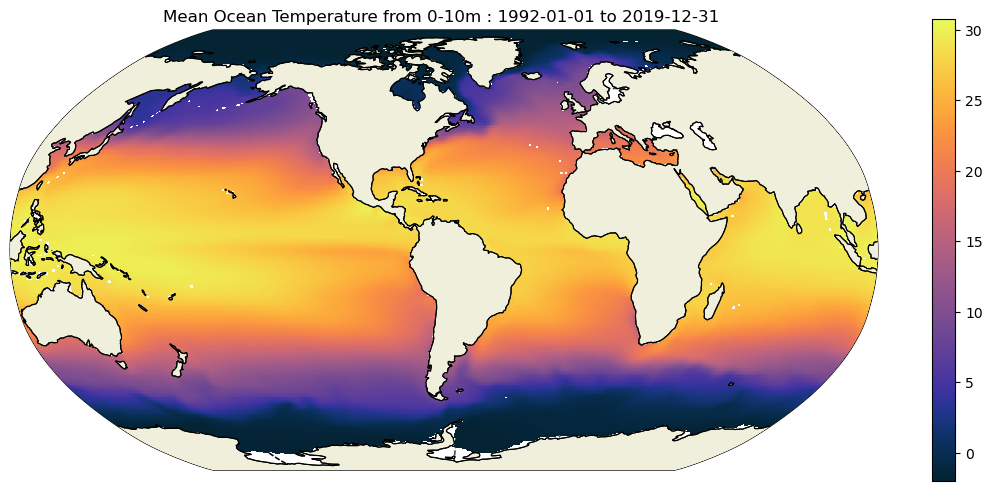

In [31]:
plt.figure(figsize=[14,6]);

ecco.plot_proj_to_latlon_grid(T_mean_k0.XC, T_mean_k0.YC, 
                              T_mean_k0, 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-2, cmax=T_mean_k0.max(), 
                              cmap=cmocean.cm.thermal);

plt.title(f'Mean Ocean Temperature from 0-10m : {str(ds.time_bnds[0][0].values)[:10]} to ' +
                    f'{str(ds.time_bnds[-1][-1].values)[:10]} ')

## METHOD 2: "DIRECT" LOADING FILES STORED ON AWS S3

### PART 1: V4R4 FILES ON PODAAC

### Find files

First we have to find the file locations on s3.  One way to do this is make an api request to the NASA EarthData 'CMR' Common Metadata Repository

In [32]:
# It helps if you know the "Short Name" of the dataset
#https://search.earthdata.nasa.gov/search/granules?p=C1991543742-POCLOUD
ShortName = 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4'

In [33]:
# search granules for a collection
response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.json", 
                            params={'ShortName':ShortName})

print(f'a code=200 means CMR is working: code {response.status_code}')

response_json = response.json()['feed']['entry']

# CMR send back a lot of information
pprint(response_json[0])

a code=200 means CMR is working: code 200
{'boxes': ['-90 -180 90 180'],
 'browse_flag': False,
 'collection_concept_id': 'C1991543813-POCLOUD',
 'coordinate_system': 'CARTESIAN',
 'data_center': 'POCLOUD',
 'dataset_id': 'ECCO Sea Surface Height - Monthly Mean llc90 Grid (Version 4 '
               'Release 4)',
 'day_night_flag': 'UNSPECIFIED',
 'granule_size': '1.850128173828125E-4',
 'id': 'G1997196540-POCLOUD',
 'links': [{'href': 's3://podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r4_native_llc0090.nc',
            'hreflang': 'en-US',
            'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
            'title': 'This link provides direct download access via S3 to the '
                     'granule.'},
           {'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r4_native_llc0090.nc',
            'hrefl

In [151]:
# Lets select a time range
StartDate='1992-01-01'
EndDate  ='1996-12-31' 

In [152]:
# CMR can only return up to 2000 files
# so be careful about what you search for
input_search_params = {'ShortName' : ShortName,
                       'temporal'  : f"{StartDate} , {EndDate}",  
                       'page_size' :2000}

In [153]:
# search granules for a collection
response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.json", 
                            params=input_search_params)

response_json = response.json()['feed']['entry']
print(f'# of file paths returned {len(response_json)} entries')

# 60 is < 2000, so we're good

# of file paths returned 60 entries


In [154]:
# Extract the filenames for these 60 garnules

s3_podaac_paths=[]

# loop through the json
for rj in response_json:
    links = rj['links']
    # loop through all the links
    for link in links:
        # see if there is a 'title' key and a 'direct download access' entry
        if 'title' in link.keys():
            if 'direct download access via S3' in link['title']:
                s3_podaac_paths.append(link['href'])

print('full path ', s3_podaac_paths[0])
pprint([Path(x).name for x in s3_podaac_paths])

full path  s3://podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r4_native_llc0090.nc
['SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-02_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-03_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-04_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-05_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-06_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-07_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-08_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-09_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-10_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-11_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-12_ECCO_V4r4_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1993-01_

In [208]:

# set up your credentials for NASA EarthData
# requires your .netrc file is set up correctly

s3, credentials = init_S3FileSystem(use_earthdata=True)

#### open a single granule hosted on PO-CLOUD

In [209]:
with s3.open(s3_podaac_paths[0], mode='rb') as f:
    ds = xr.open_dataset(f, engine='h5netcdf').load()
ds

<xarray.Dataset> Size: 7MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 8B 1992-01-16T18:00:00
    ...         ...
    YC         (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    XG         (tile, j_g, i_g) float32 421kB -115.0 -115.0 ... -102.9 -109.0
    YG         (tile, j_g, i_g) float32 421kB -88.18 -88.32 ... -87.99 -88.02
    time_bnds  (time, nv) datetime64[ns] 16B 1992-01-01T12:00:00 1992-02-01
    XC_bnds    (tile, j, i, nb) float32 2MB -115.0 -115.0 ... -115.0 -108.5
    YC_bnds    (tile, j, i, nb) float32 2MB -88.18 -88.32 ... -88.18 -88.16
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    SSHIBC     (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    SSHNOIBC   (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
    ETAN       (time, tile, j, i) float32 421kB nan nan nan nan ... nan nan nan
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         9302811e-400c-11eb-b69e-0cc47a3f49c3

#### open multiple granules hosted on PO-CLOUD

In [210]:
# number to load
ns = [1, 10, 60] 
time_ns = []

for n in ns:
    files_to_load = s3_podaac_paths[:n]

    start_time = time.time()

    # pre-open the files
    file_objects = [s3.open(p, mode='rb') for p in files_to_load]
    # load into memory
    multiple_granules = xr.open_mfdataset(file_objects, 
                                          parallel=True, data_vars='minimal',\
                                          coords='minimal',compat='override',
                                          combine='nested', concat_dim='time', 
                                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90}).load()
    
    total_time = time.time() - start_time

    print(f'\nloaded {len(multiple_granules.time)} granule(s)')
    print(f'total time {total_time:.2f} sec for {len(multiple_granules.time.values)} granules')
    print(f'time per granule {total_time/len(files_to_load):.2f} sec/gran')
    
    time_ns.append(total_time)


loaded 1 granule(s)
total time 0.93 sec for 1 granules
time per granule 0.93 sec/gran

loaded 10 granule(s)
total time 2.87 sec for 10 granules
time per granule 0.29 sec/gran

loaded 60 granule(s)
total time 16.35 sec for 60 granules
time per granule 0.27 sec/gran


(0.0, 2.0)

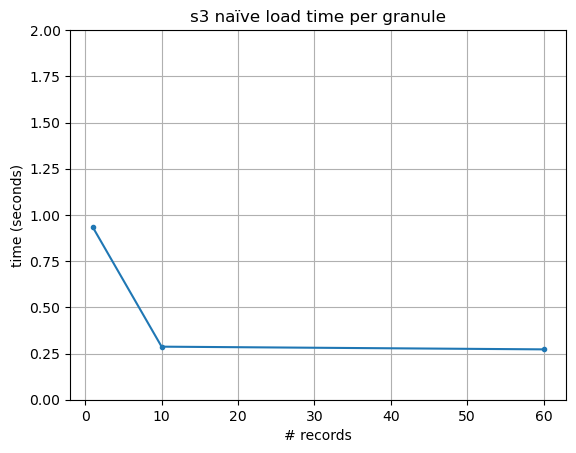

In [211]:
plt.plot(ns, np.array(time_ns)/np.array(ns),'.-');
plt.title('s3 naïve load time per granule');plt.xlabel('# records');plt.ylabel('time (seconds)')
plt.grid()
plt.ylim([0, 2])

In [212]:
# 0.25 * 336 = 36.6 seconds to lazy load all monthly fields in to memory
print(f'{0.25*336} seconds for 30 years of monthly fields')

# all 30 years of daily fields
# 0.25 second per file, 30 years, 366 days per year
print(f'{0.25*30*366} seconds for 30 years of daily fields')
print(f'{0.25*30*366/60} minutes for 30 years of daily fields')


84.0 seconds for 30 years of monthly fields
2745.0 seconds for 30 years of daily fields
45.75 minutes for 30 years of daily fields


##### Compare with lazy load

In [214]:
# number to load
ns = [1, 10, 60] 

time_ns = []

for n in ns:
    files_to_load = s3_podaac_paths[:n]

    start_time = time.time()

    # pre-open the files
    file_objects = [s3.open(p, mode='rb') for p in files_to_load]
    
    # lazy-load 
    multiple_granules = xr.open_mfdataset(file_objects, 
                                          parallel=True, data_vars='minimal',\
                                          coords='minimal',compat='override',
                                          combine='nested', concat_dim='time', 
                                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})
    
    total_time = time.time() - start_time

    print(f'\nlazy-loaded {len(multiple_granules.time)} granule(s)')
    print(f'total time {total_time:.2f} sec for {len(multiple_granules.time.values)} granules')
    print(f'time per granule {total_time/len(files_to_load):.2f} sec/gran')
    
    time_ns.append(total_time)


lazy-loaded 1 granule(s)
total time 0.26 sec for 1 granules
time per granule 0.26 sec/gran

lazy-loaded 10 granule(s)
total time 1.34 sec for 10 granules
time per granule 0.13 sec/gran

lazy-loaded 60 granule(s)
total time 6.10 sec for 60 granules
time per granule 0.10 sec/gran


(0.0, 0.5)

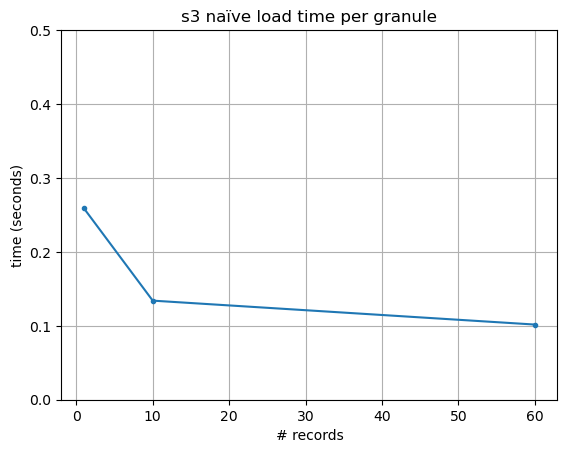

In [215]:
plt.plot(ns, np.array(time_ns)/np.array(ns),'.-');
plt.title('s3 naïve load time per granule');plt.xlabel('# records');plt.ylabel('time (seconds)')
plt.grid()
plt.ylim([0, .5])

In [216]:
# 0.1 * 336 = 36.6 seconds to lazy load all monthly fields in to memory
print(f'{0.1*336} seconds for 30 years of monthly fields')

# all 30 years of daily fields
# 0.1 second per file, 30 years, 366 days per year
print(f'{0.1*30*366} seconds for 30 years of daily fields')
print(f'{0.1*30*366/60} minutes for 30 years of daily fields')


33.6 seconds for 30 years of monthly fields
1098.0 seconds for 30 years of daily fields
18.3 minutes for 30 years of daily fields


### PART 2: V4R5 FILES ON ECCO S3 BUCKET 'ECCO-MODEL-GRANULES'



### Find files

In [217]:
s3, credentials = init_S3FileSystem()

In [218]:
bucket='ecco-model-granules'


prefix='/netcdf/V4r5/native/mon_mean/'
#prefix='/netcdf/V4r5/native/day_mean/'
#prefix='/netcdf/V4r5/latlon/snap/'
#prefix='/netcdf/V4r5/native/geometry/'

#prefix='/netcdf/V4r5/latlon/mon_mean/'
#prefix='/netcdf/V4r5/latlon/day_mean/'
#prefix='/netcdf/V4r5/latlon/snap/'
#prefix='/netcdf/V4r5/latlon/geometry/'

In [219]:
mon_mean_latlon_datasets = s3.ls(bucket + prefix)
pprint(mon_mean_latlon_datasets)

['ecco-model-granules/netcdf/V4r5/native/mon_mean/ATM_SURFACE_TEMP_HUM_WIND_PRES',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/ICE_FRONT_FLUX',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/ICE_SHELF_FLUX',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_X',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_Y',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_X',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_Y',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_X',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_Y',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_AND_ICE_SURFACE_FW_FLUX',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS',
 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_

In [222]:
search_path = 'ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_TEMPERATURE_SALINITY'
obs_files_on_s3 = s3.ls(search_path)

print(f'# of files in path {len(obs_files_on_s3)}\n')
# show the filenames of the first 5 files
pprint([Path(x).name for x in obs_files_on_s3[0:5]])
print('\n')

# of files in path 336

['OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']




#### Open a single granule into memory 

In [223]:
file_to_open=obs_files_on_s3[0]
print(file_to_open)
# a proper s3 path [bucket + prefix]
with s3.open(file_to_open, mode='rb') as f:
    ds = xr.open_dataset(f, engine='h5netcdf')
ds

ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_TEMPERATURE_SALINITY/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc


<xarray.Dataset> Size: 47MB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B ...
    Zl         (k_l) float32 200B ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    YC_bnds    (tile, j, i, nb) float32 2MB ...
    Z_bnds     (k, nv) float32 400B ...
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 21MB ...
    SALT       (time, k, tile, j, i) float32 21MB ...
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            8a5175e0-2719-11f0-9a28-0a58a9feac02

#### Open a multiple granules into memory 

In [231]:

# load 12 records into memroy
files_to_load = obs_files_on_s3[:48]

print(files_to_load[0])
start_time = time.time()

# "open" the files using s3fs
file_objects = [s3.open(p, mode='rb') for p in files_to_load]

# load into memory
multiple_granules = xr.open_mfdataset(file_objects, 
                                      parallel=True, data_vars='minimal',\
                                      coords='minimal',compat='override',
                                      combine='nested', concat_dim='time',
                                      chunks={'time':4, 'tile':13,' k':50,'j':90,'i':90}).load()

total_time = time.time() - start_time

print('\nloaded multiple granules')
print(f'total time {total_time:.2f} sec for {len(multiple_granules.time.values)} granules')
print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')

ecco-model-granules/netcdf/V4r5/native/mon_mean/OCEAN_TEMPERATURE_SALINITY/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc

loaded multiple granules
total time 22.34 sec for 48 granules
time per granule 0.47 grans/sec


In [228]:
# load multiple # of files 
ns = [1, 12, 48] 
time_ns = []

for n in ns:
    files_to_load = obs_files_on_s3[:n]

    start_time = time.time()

    # pre-open the files
    file_objects = [s3.open(p, mode='rb') for p in files_to_load]
    # first lazy-load
    multiple_granules = xr.open_mfdataset(file_objects, 
                                          parallel=True, data_vars='minimal',\
                                          coords='minimal',compat='override',
                                          combine='nested', concat_dim='time',
                                          chunks={'time':4, 'tile':13,' k':50,'j':90,'i':90}).load()
    # then actual load.
    multiple_granules.load()
    total_time = time.time() - start_time

    print('\nloaded multiple granules')
    print(f'total time {total_time:.2f} sec for {len(multiple_granules.time.values)} granules')
    print(f'time per granule {total_time/len(files_to_load):.2f} grans/sec')
    
    time_ns.append(total_time)


loaded multiple granules
total time 1.00 sec for 1 granules
time per granule 1.00 grans/sec

loaded multiple granules
total time 6.14 sec for 12 granules
time per granule 0.51 grans/sec

loaded multiple granules
total time 24.49 sec for 48 granules
time per granule 0.51 grans/sec


(0.0, 1.0)

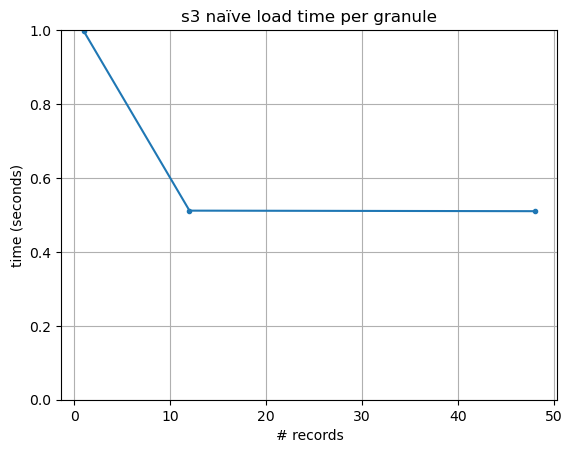

In [229]:
plt.plot(ns, np.array(time_ns)/np.array(ns),'.-');
plt.title('s3 naïve load time per granule');plt.xlabel('# records');plt.ylabel('time (seconds)')
plt.grid()
plt.ylim([0, 1])

## METHOD 3: "REFERENCE" LOADING FILES STORED ON AWS S3

### PART 1: V4R5 FILES ON PODAAC

### Find files

Kerchunk files on ecco-model-granules s3 bucket

In [5]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);

In [6]:
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

In [7]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_FW_FLUX_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_FW_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_STRESS_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/O

In [8]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41595")
client

<Client: 'tcp://127.0.0.1:41595' processes=4 threads=4, memory=15.61 GiB>

In [38]:
# MZZ files have been downloaded. 

# select the temperature/salinity dataset
mzz_local_file= mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_latlon_llc090_ECCOV4r5.json'
print(mzz_local_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_TEMPERATURE_SALINITY_mon_mean_latlon_llc090_ECCOV4r5.json


In [9]:
import fsspec
import zarr

In [40]:
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

ds

<xarray.Dataset> Size: 35GB
Dimensions:         (time: 336, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    time_bnds       (time, nv) datetime64[ns] 5kB dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 17GB dask.array<chunksize=(4, 50, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 17GB dask.array<chunksize=(4, 50, 180, 360), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            82102962-2719-11f0-a27e-0a58a9feac02

In [41]:
lon_mg, lat_mg  = np.meshgrid(ds.longitude, ds.latitude)

In [47]:
mean_SST = ds.THETA.isel(Z=0).mean(dim='time').compute()

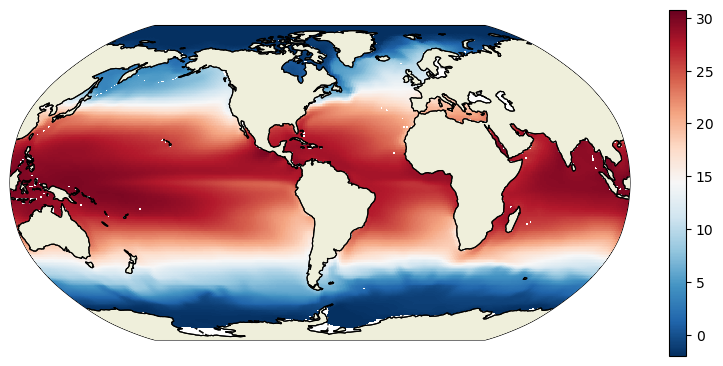

In [48]:
plt.figure(figsize=[10,4.5]);
ecco.plot_proj_to_latlon_grid(lon_mg, 
                              lat_mg, 
                              mean_SST, 
                              user_lon_0=-67, show_colorbar=True);

#  SOME CALCULATIONS: Select Box for ENSO comparison

In [49]:
lon_mg, lat_mg = np.meshgrid(ds.longitude, ds.latitude)

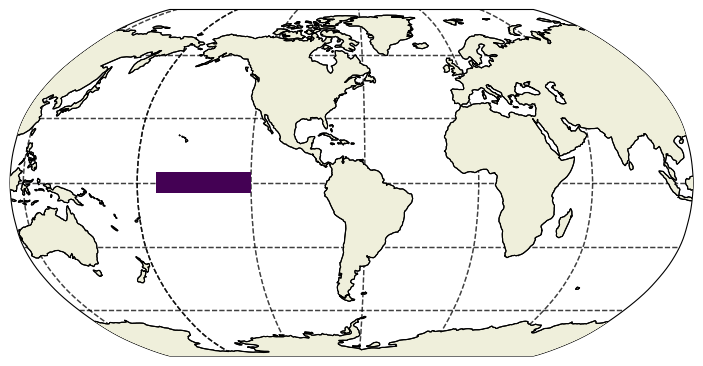

In [50]:
# Niño 3.4 (5N-5S, 170W-120W):  

# tweak as needed
box_lat = np.logical_and(mean_SST.latitude > -5, mean_SST.latitude < 5)
box_lon = np.logical_and(mean_SST.longitude > -170, mean_SST.longitude < -120)
box = np.logical_and(box_lat, box_lon)

# make mask, 1 in box, nan outside of box
mask = np.where(box, 1, np.nan)

# convert the mask into a data arraya
mask_DA = xr.DataArray(mask, dims=['latitude','longitude'],
                           coords={'latitude':ds.latitude,
                                   'longitude':ds.longitude})


# show box
plt.figure(figsize=[10,4.5]);
ecco.plot_proj_to_latlon_grid(lon_mg, 
                              lat_mg, 
                              mask_DA, 
                              user_lon_0=-67);

In [51]:
# calculate T mean in space (rough, assumes all horizontal grid cells are equal size)
st = time.time()

T_in_box = (ds.THETA*mask_DA).mean(dim=['latitude','longitude']).compute()

total_time = time.time() - st
# compute time with 4 workers on baby ec2 is 
print('total time to compute ', total_time)

total time to compute  48.93117141723633


In [52]:
print(ds.THETA.shape)
mem = 336*60*360*720*4
print(f'All of monthly-mean THETA in memory would require ~{mem/1e9} gb')

(336, 50, 360, 720)
All of monthly-mean THETA in memory would require ~20.901888 gb


In [53]:
# calculate the time mean of the the T_in_box
# operate on the intermediate field, T_in_box, rather than on ds.THETA
T_in_box_time_mean = T_in_box.mean(dim='time')

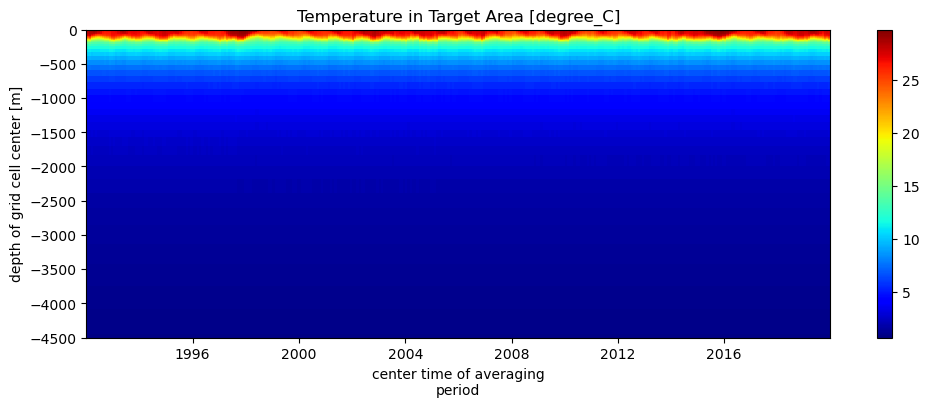

In [54]:
plt.figure(figsize=[12,4])
T_in_box.T.plot(cmap='jet')
plt.ylim([-4500, 0])
plt.title(f'Temperature in Target Area [{ds.THETA.attrs["units"]}]');

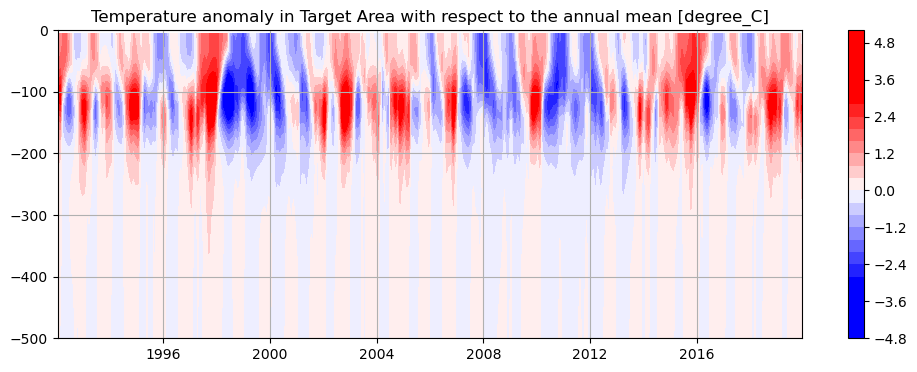

In [58]:
plt.figure(figsize=[12,4])
plt.contourf(T_in_box.time, T_in_box.Z, (T_in_box - T_in_box_time_mean).T, 30,
             cmap='bwr', vmin=-3, vmax=3);
plt.grid()
plt.colorbar()
plt.ylim([-500, 0])
plt.title(f'Temperature anomaly in Target Area with respect to the annual mean [{ds.THETA.attrs["units"]}]');

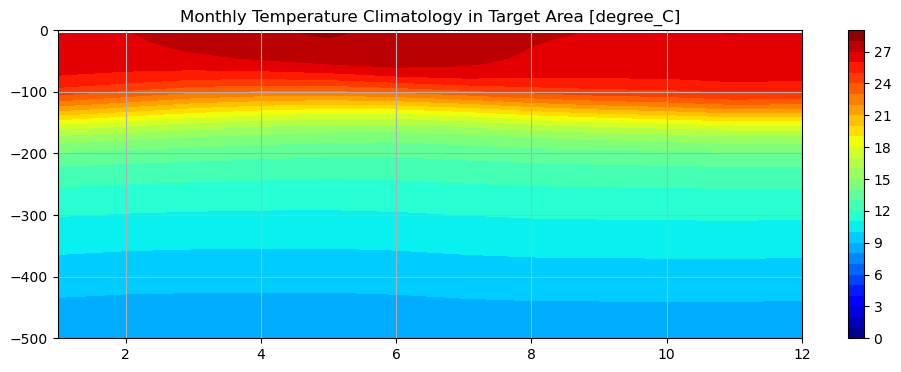

In [60]:
# Calculate monthly climatology
T_in_box_monthly_clim = T_in_box.groupby("time.month").mean()

plt.figure(figsize=[12,4])
plt.contourf(T_in_box_monthly_clim.month, T_in_box_monthly_clim.Z, T_in_box_monthly_clim.T, 
            30, cmap='jet')
plt.grid()
plt.colorbar()
plt.ylim([-500, 0])
plt.title(f'Monthly Temperature Climatology in Target Area [{ds.THETA.attrs["units"]}]');

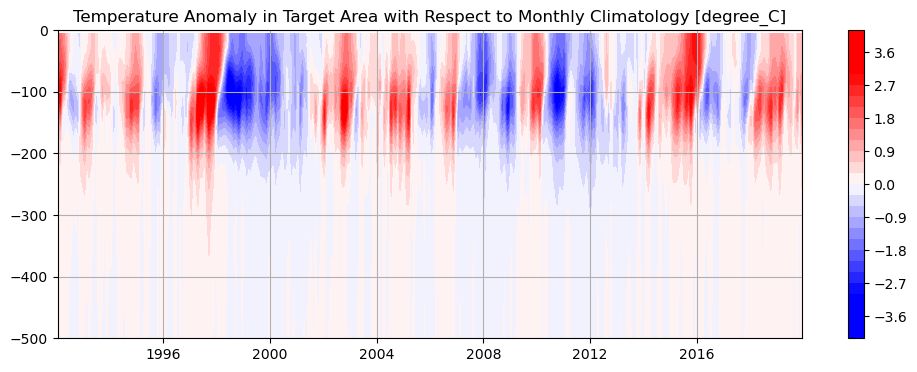

In [61]:
# Calculate anomaly with respect to the monthly climatology

T_in_box_anomaly = T_in_box.groupby('time.month')-T_in_box_monthly_clim


plt.figure(figsize=[12,4])
plt.contourf(T_in_box.time, T_in_box.Z, T_in_box_anomaly.T, 30,
             cmap='bwr', vmin=-3, vmax=3);
plt.grid()
plt.colorbar()
plt.ylim([-500, 0])
plt.title(f'Temperature Anomaly in Target Area with Respect to Monthly Climatology [{ds.THETA.attrs["units"]}]');

#  Ice bridge in ECCO

In [30]:
import cmocean

In [13]:
# MZZ files have been downloaded. 

# select the temperature/salinity dataset
TS_mzz_local_file= mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_day_mean_native_llc090_ECCOV4r5.json'
print(TS_mzz_local_file)

# select sea ice
SIconc_mzz_local_file= mzz_local_directory / 'SEA_ICE_CONC_THICKNESS_day_mean_native_llc090_ECCOV4r5.json'
print(SIconc_mzz_local_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_TEMPERATURE_SALINITY_day_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/SEA_ICE_CONC_THICKNESS_day_mean_native_llc090_ECCOV4r5.json


In [15]:
# TS
fs = fsspec.filesystem("reference",     
                       fo=str(TS_mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
TS_ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

In [17]:
# Sea ice conc
fs = fsspec.filesystem("reference",     
                       fo=str(SIconc_mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
SIconc_ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

In [55]:
sss_da = TS_ds.SALT.isel(k=0,tile=6)
sic_da = SIconc_ds.SIarea.isel(tile=6)*100

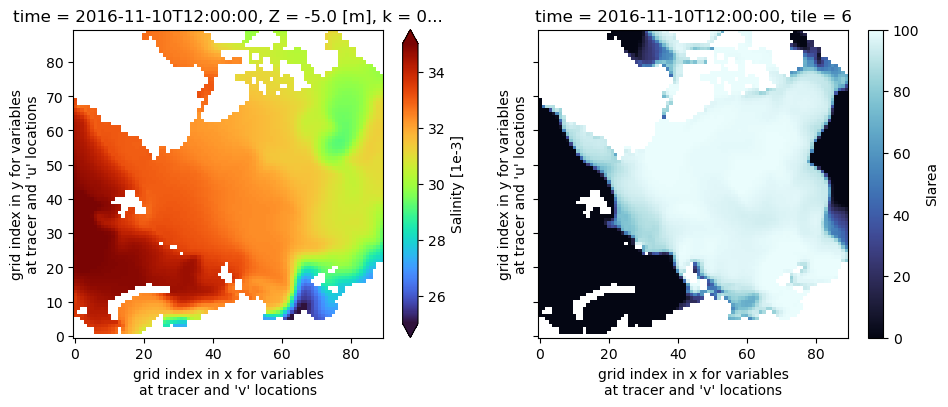

In [62]:
date = '2016-11-10'

fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=[11,4])
sss_da.sel(time=date).plot(ax=ax1,vmin=25,vmax=35,cmap='turbo');
sic_da.sel(time=date).plot(ax=ax2,vmin=0,vmax=100,cmap=cmocean.cm.ice);
# ax1.set_xlim(0,10);
# ax1.set_ylim(50,90);

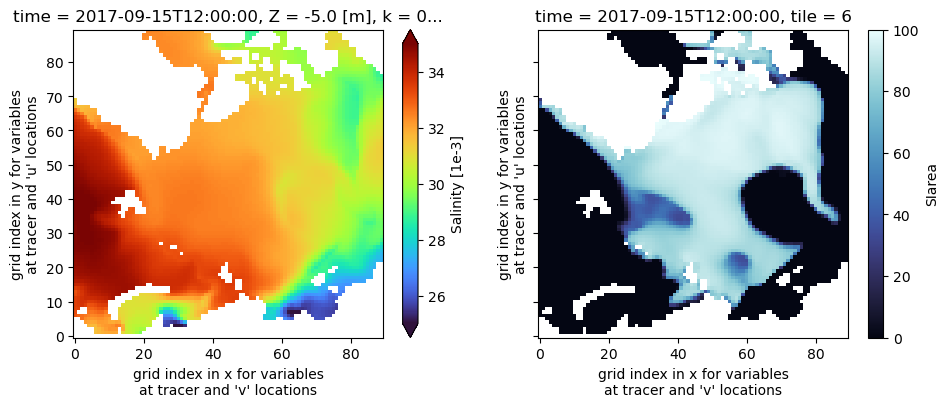

In [69]:
date = '2017-09-15'

fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=[11,4])
sss_da.sel(time=date).plot(ax=ax1,vmin=25,vmax=35,cmap='turbo');
sic_da.sel(time=date).plot(ax=ax2,vmin=0,vmax=100,cmap=cmocean.cm.ice);
# ax1.set_xlim(0,10);
# ax1.set_ylim(50,90);

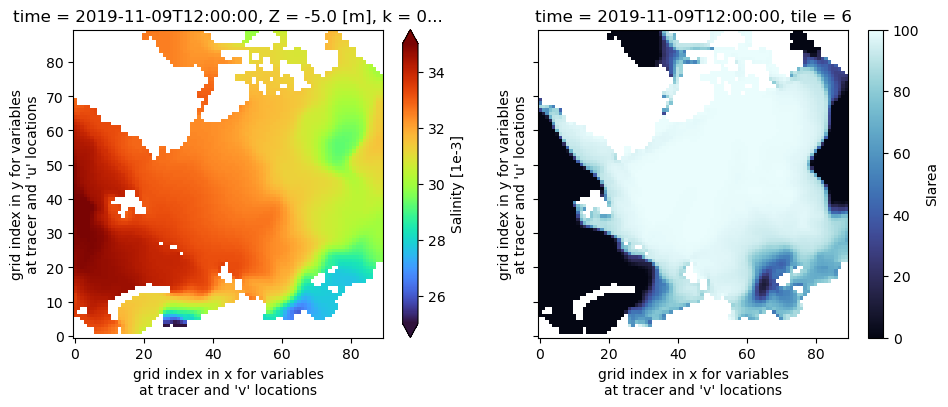

In [56]:
date = '2019-11-09'

fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=[11,4])
sss_da.sel(time=date).plot(ax=ax1,vmin=25,vmax=35,cmap='turbo');
sic_da.sel(time=date).plot(ax=ax2,vmin=0,vmax=100,cmap=cmocean.cm.ice);
# ax1.set_xlim(0,10);
# ax1.set_ylim(50,90);

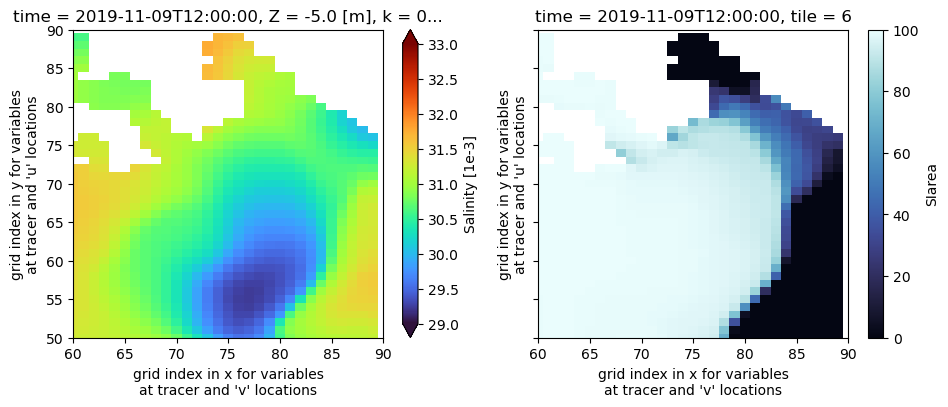

In [66]:
date = '2019-11-09'

fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=[11,4])
sss_da.sel(time=date).plot(ax=ax1,vmin=29,vmax=33,cmap='turbo');
sic_da.sel(time=date).plot(ax=ax2,vmin=0,vmax=100,cmap=cmocean.cm.ice);
ax1.set_xlim(60,90);
ax1.set_ylim(50,90);

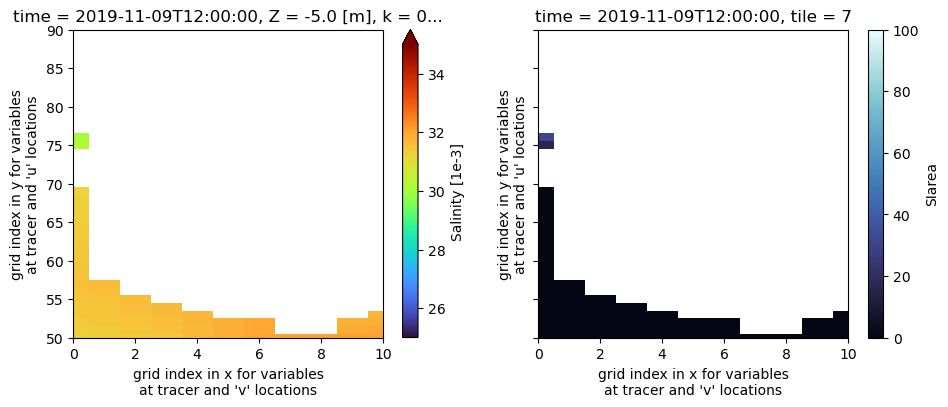

In [54]:
date = '2019-11-09'

fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=[11,4])
sss_da.sel(time=date).plot(ax=ax1,vmin=25,vmax=35,cmap='turbo');
sic_da.sel(time=date).plot(ax=ax2,vmin=0,vmax=100,cmap=cmocean.cm.ice);
ax1.set_xlim(0,10);
ax1.set_ylim(50,90);

Mean Ocean Temperature from 0-10m : 
1992-01-01
1996-01-01


<Figure size 1400x600 with 0 Axes>

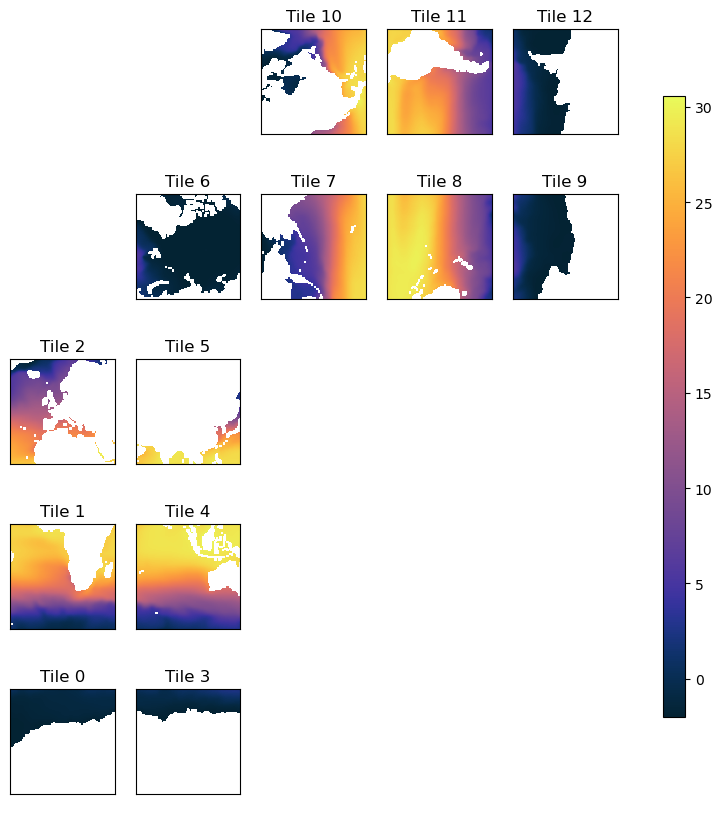

In [17]:
# Butterfly

plt.figure(figsize=[14,6]);

ecco.plot_tiles(T_mean_k0, show_colorbar=True, 
                cmin=-2, cmax=T_mean_k0.max(), cmap=cmocean.cm.thermal);

print(f'Mean Ocean Temperature from 0-10m : ')
print(f'{str(ds.time_bnds[0][0].values)[:10]}')
print(f'{str(ds.time_bnds[-1][-1].values)[:10]}')